In [1]:
# Luminosities
# Get luminosities from Camels data, and combine it with a grid and use UVM2 filters to splot a luminosity function.
import numpy as np
import matplotlib.pyplot as plt
from unyt import Myr
import h5py
import hdf5plugin

from synthesizer.grid import Grid, get_available_lines
from synthesizer.load_data.load_camels import load_CAMELS_IllustrisTNG
from synthesizer.sed import Sed
from synthesizer.filters import UVJ
import numpy as np
from synthesizer.filters import Filter, FilterCollection
from synthesizer.exceptions import WavelengthOutOfRange, InconsistentWavelengths
import matplotlib as mpl
import matplotlib.cm as cm
import os
from unyt import Angstrom, Hz, um, eV
from synthesizer.igm import Madau96


# Luminosity Function Calc
def luminosity_fun(luminosity, V, nbins):
    # luminosity is our luminosity data in Lsol
    # V is comoving Survey volume Vcom = Vphys(1+z)^3
    # nbins is number of bins

    L     = luminosity        # Read stellar luminosities in Lsun
    logL  = np.log10(L)       # Take logarithm

    # calc histogram
    Phi, edg = np.histogram(logL, bins=nbins)  # Unnormalized histogram and bin edges

    dL    = edg[1] - edg[0]                    # Bin size
    Lax   = edg[0:-1] + dL/2.                  # Luminosity axis
    Phi   = Phi / V / dL                       # Normalize to volume and bin size

    return Phi, Lax


In [2]:
# Define the grid
grid_name = "bc03-2016-Miles_chabrier-0.1,100.hdf5"
grid_dir = "/Users/am/Documents/CAMELS/data/grids/"
grid = Grid(grid_name, grid_dir=grid_dir, read_lines=False)
print(grid)

------------------------------
SUMMARY OF GRID
log10age: [ 5.          5.          5.14998846  5.20000187  5.25000503  5.3000082
  5.3499959   5.40000235  5.45000263  5.50000307  5.55000809  5.60000309
  5.65000623  5.7000024   5.74999898  5.80000183  5.85000259  5.90000097
  5.95000442  6.          6.01998816  6.04000864  6.06001754  6.08001285
  6.09999123  6.12001425  6.14000495  6.15998805  6.18001112  6.20000187
  6.22000343  6.23999979  6.2599998   6.28000895  6.3000082   6.3200008
  6.34000762  6.36000613  6.37999404  6.40000235  6.42000528  6.43999547
  6.45999526  6.48000694  6.50000307  6.51999853  6.54000394  6.56000233
  6.58000069  6.60000309  6.62000064  6.64000415  6.66000172  6.67999992
  6.7000024   6.7200021   6.73999931  6.76000005  6.7800003   6.80000183
  6.81999773  6.83999939  6.86000242  6.88000139  6.90000097  6.91999803
  6.93999821  6.9599996   6.97999882  7.          7.01998816  7.04000864
  7.06001754  7.08001285  7.09999123  7.11998131  7.14000495  7.15998

In [3]:
# create a galaxy from our snapshot data
# This creates gals, which is a synthesizer.Galaxy object, for each structure in the subdinf file.
# These galaxy objects contain lots of useful methods for acting on galaxies, in addition to component parts of a galaxy
# These components contain stars, gas and black holes.
gals = load_CAMELS_IllustrisTNG(
    "../../synthesizer/tests/data/",
    snap_name="snap_000.hdf5",
    fof_name="fof_subhalo_tab_000.hdf5",
)

len(gals)
print(gals)

# to get the intrisic spectrum of the stellar component we do:
g = gals[1]
spec = g.stars.get_spectra_incident(grid)
# Here we grab a single galaxy, and call stars.get_spectra_incident, 
# providing our grid object as the first argument. This returns the spectra as an Sed object
print(g)
print(spec)

/Users/am/anaconda3/envs/allyenv/lib/python3.9/site-packages/unyt/array.py:1938: RuntimeWarning: invalid value encountered in divide
  out_arr = func(


[<synthesizer.particle.galaxy.Galaxy object at 0x157376ca0>, <synthesizer.particle.galaxy.Galaxy object at 0x157376670>, <synthesizer.particle.galaxy.Galaxy object at 0x157376850>, <synthesizer.particle.galaxy.Galaxy object at 0x157376040>, <synthesizer.particle.galaxy.Galaxy object at 0x157376ac0>, <synthesizer.particle.galaxy.Galaxy object at 0x1573767c0>, <synthesizer.particle.galaxy.Galaxy object at 0x15736f940>, <synthesizer.particle.galaxy.Galaxy object at 0x15736f7c0>, <synthesizer.particle.galaxy.Galaxy object at 0x15736f6a0>, <synthesizer.particle.galaxy.Galaxy object at 0x15736f580>, <synthesizer.particle.galaxy.Galaxy object at 0x15736f3d0>, <synthesizer.particle.galaxy.Galaxy object at 0x15736fa00>, <synthesizer.particle.galaxy.Galaxy object at 0x15736fd60>, <synthesizer.particle.galaxy.Galaxy object at 0x15736fe50>, <synthesizer.particle.galaxy.Galaxy object at 0x15736f7f0>, <synthesizer.particle.galaxy.Galaxy object at 0x15736f670>, <synthesizer.particle.galaxy.Galaxy obj

In [4]:
# To access the luminosity and wavelength for _spec we can now do

spec.lam[:10], spec.lnu[:10]


(unyt_array([ 5.5999999 ,  6.5       ,  7.4000001 ,  8.30000019,  9.19999981,
        10.1000004 , 11.        , 11.8999996 , 12.8000002 , 13.6999998 ], '√Ö'),
 unyt_array([1.13419935e-02, 6.96210021e-01, 2.96070369e+01, 5.87992388e+02,
        9.16576748e+03, 1.23829224e+05, 1.31708803e+06, 1.04562426e+07,
        6.10081169e+07, 2.64077144e+08], 'erg/(Hz*s)'))

In [5]:
wavel = spec.lam
lums = spec.lnu

print('wavelength:', wavel)
print('luminosity:',lums)

wavelength: [5.5999999e+00 6.5000000e+00 7.4000001e+00 ... 1.6000000e+08 2.4000000e+08
 3.6000000e+08] √Ö
luminosity: [1.13419935e-02 6.96210021e-01 2.96070369e+01 ... 2.91600931e+20
 1.29600493e+20 5.76002510e+19] erg/(Hz*s)


In [6]:
# now get the filter codes for XMM-OM
lams_xmm = np.linspace(1883.78, 2994.45, 1000) # using min and max values from wavelength given from SVO

fil_uvm2_XMM = Filter("XMM/OM.UVM2", new_lam=lams_xmm)

# filter_codes = [f"JWST/NIRCam.{f}" for f in ["F070W", "F444W"]]
filter_codes = ["XMM/OM.UVM2"] 
svo_fil_xmm = FilterCollection(filter_codes=filter_codes, new_lam=lams_xmm)


In [7]:
# now get for UVOT
lams_uvot = np.linspace(1699.08, 2964.30, 1000) # using min and max values from wavelength given from SVO

fil_uvm2_UVOT = Filter("Swift/UVOT.UVM2", new_lam=lams_xmm)

filter_codes = ["Swift/UVOT.UVM2",  "XMM/OM.UVM2"] 
print(filter_codes)
svo_fil_uvot = FilterCollection(filter_codes=filter_codes, new_lam=lams_uvot)

['Swift/UVOT.UVM2', 'XMM/OM.UVM2']


In [8]:
# make filter collection with both UVOT and OM 
#  passing the filters to the grid to limit the wavelength values.
filt_lst = [fil_uvm2_UVOT, fil_uvm2_XMM]

combined_filters = FilterCollection(
    filters=filt_lst, new_lam=lams_xmm
)

print(combined_filters)

for i in combined_filters:
    print(i)

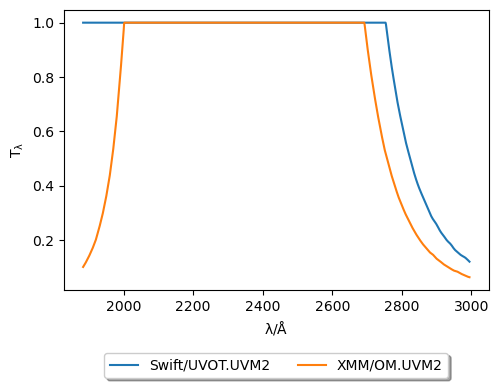

In [9]:
fig, ax = combined_filters.plot_transmission_curves(show=True)


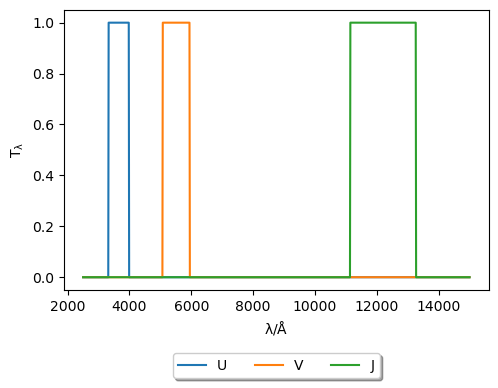

In [10]:
from synthesizer.filters import UVJ

lams = np.linspace(2500, 15000, 1000)
fc = UVJ(new_lam=lams)
fig, ax = fc.plot_transmission_curves(show=True)

In [11]:
#¬†Now add filter to instrument  to get photometry for that filter:
# Survey Example
from synthesizer.survey import Survey
# Set up a filter collection object (UVJ default)
# and we have combined_filters
fc_ujv = UVJ(new_lam=grid.lam)
fc_uvm2 = combined_filters

# Convert gals to an array
gals = np.array(gals)

# Create an empty Survey object
survey_uvj = Survey(super_resolution_factor=1)
survey_uvm2 = Survey(super_resolution_factor=1)

#¬†Let‚Äôs add the filters to an instrument in the survey
survey_uvj.add_photometric_instrument(filters=fc_ujv, label="UVJ")
survey_uvm2.add_photometric_instrument(filters=fc_uvm2, label="UVM2")

#¬†Store the galaxies in the survey
survey_uvj.add_galaxies(gals)
survey_uvm2.add_galaxies(gals)

In [12]:
print('Survey UVJ: ', survey_uvj)
print('Survey UVM2: ', survey_uvm2)

Survey UVJ:  <synthesizer.survey.Survey object at 0x107720730>
Survey UVM2:  <synthesizer.survey.Survey object at 0x29147fc70>


In [38]:
print(dir(survey_uvm2))
print('Number of survey filters: ', survey_uvm2.nfilters)

print(dir(survey_uvj))
print('Number of survey filters: ', survey_uvj.nfilters)


['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_check_survey_args', 'add_galaxies', 'add_photometric_instrument', 'add_spectral_instrument', 'convert_mag_depth_to_fnu', 'convert_mag_depth_to_fnu0', 'convert_mag_depth_to_lnu', 'cosmo', 'fov', 'galaxies', 'get_particle_spectra', 'get_photometry', 'get_spectra', 'imgs', 'instruments', 'make_field_ifu', 'make_field_image', 'make_ifus', 'make_images', 'nfilters', 'ngalaxies', 'ninstruments', 'photometry', 'seds', 'super_resolution_factor']
Number of survey filters:  2
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', 

In [60]:
# trying to get spectra from all galaxies
g = gals[1]
spec_sur = survey_uvm2.get_spectra(grid=grid, spectra_type="incident")
phot_sur = survey_uvm2.get_photometry(spectra_type="incident")

print(spec_sur)
print('photometry: ',phot_sur)


None
photometry:  {'Swift/UVOT.UVM2': unyt_array([ 5.80128943e+21,  4.83795951e+20,  5.10570388e+19, ...,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00], 'erg/(Hz*cm**2*s)'), 'XMM/OM.UVM2': unyt_array([ 5.65694474e+21,  4.67593519e+20,  5.05824579e+19, ...,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00], 'erg/(Hz*cm**2*s)')}


----------
SUMMARY OF PARAMETERISED STAR FORMATION HISTORY
<class 'synthesizer.parametric.sf_hist.Constant'>
duration: 100 Myr
median age: 50.00 Myr
mean age: 50.00 Myr
----------

----------
SUMMARY OF BINNED SFZH
median age: 50.00 Myr
mean age: 49.99 Myr
mean metallicity: 0.0080
----------



(<Figure size 350x500 with 1 Axes>,
 <Axes: xlabel='$\\lambda/[\\mathrm{√Ö}]$', ylabel='$L_{\\nu}/[\\mathrm{erg\\ / \\ (Hz s)}]$'>)

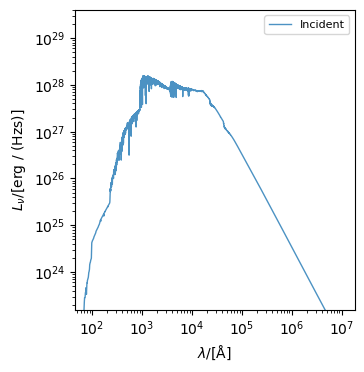

In [56]:
from synthesizer.parametric import SFH, ZDist, Stars
from synthesizer.parametric.galaxy import Galaxy

# define the functional form of the star formation and metal enrichment histories
sfh = SFH.Constant(duration=100 * Myr)  # constant star formation
print(sfh)  # print sfh summary
metal_dist = ZDist.DeltaConstant(log10metallicity=-2.0)  # constant metallicity

# get the 2D star formation and metal enrichment history for the given SPS grid. This is (age, Z).
stars = Stars(
    grid.log10age,
    grid.metallicity,
    sf_hist=sfh,
    metal_dist=metal_dist,
    initial_mass=10**8,
)
print(stars)
galaxy = Galaxy(stars)

galaxy.stars.get_spectra_incident(grid)
galaxy.stars.plot_spectra()

In [13]:
## CV_0/snap_026.hdf5
# Need to use PartType4 Masses for STELLAR Mass, not Halo mass
snap_stars  = "../../synthesizer/tests/data/snap_000.hdf5"
data = h5py.File(snap_stars, 'r')
BoxSize      = data['Header'].attrs[u'BoxSize']/1e3    #size of the snapshot in comoving Mpc/h
redshift026     = data['Header'].attrs[u'Redshift']       #reshift of the snapshot
print('Box size:                 %.2f Mpc/h'%BoxSize)
print('snapshot redshift:        %.2f'%redshift026)
# Need to use comoving volume 
#ùëâcom=ùëâphys(1+ùëß)3
Vphys = BoxSize**3 
Vcom = Vphys*(1+redshift026)**3 
print('Volume %.2f Mpc^3'%Vphys)

Box size:                 25.00 Mpc/h
snapshot redshift:        5.99
Volume 15625.00 Mpc^3


In [14]:
print(lums)

[1.13419935e-02 6.96210021e-01 2.96070369e+01 ... 2.91600931e+20
 1.29600493e+20 5.76002510e+19] erg/(Hz*s)


In [15]:
lums
# Masking inf values
mask = np.isfinite(lums)
cleaned_lums = lums[mask]

print(cleaned_lums)

[1.13419935e-02 6.96210021e-01 2.96070369e+01 ... 2.91600931e+20
 1.29600493e+20 5.76002510e+19] erg/(Hz*s)


In [61]:
def luminosity_fun2(luminosity, V, nbins):
    # Remove non-finite values
    logL = np.log10(luminosity)
    logL_finite = logL[np.isfinite(logL)]

    # Calculate histogram
    Phi, edg = np.histogram(logL_finite, bins=nbins)

    # Calculate bin size and luminosity axis
    dL = edg[1] - edg[0]
    Lax = edg[:-1] + dL / 2.
    
    # Normalize to volume and bin size
    Phi = Phi / V / dL
    
    return Phi, Lax

# get luminosity function:
bins = 10
phi, lux = luminosity_fun2(cleaned_lums, Vcom, bins)

# UNITS ARE WRONG

In [62]:
type(cleaned_lums)

unyt.array.unyt_array